# Insitu validation of synthetic LST

In [1]:
import sys
import os
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr
from scipy import stats
from matplotlib.ticker import MaxNLocator
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt

## Analysis Parameters

In [2]:
model_var='LST'
feat = 'CLIM'
base = '/g/data/os22/chad_tmp/AusENDVI/data/'

## Open datasets

In [3]:
dataset = 'synthetic'

#gridded data
ds = xr.open_dataarray(f'{base}synthetic/{model_var}/{model_var}_{feat}_synthetic_5km_monthly_1982_2022.nc')
# ds = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
ds = ds.rename(model_var)

#Ozflux data
base = '/g/data/os22/OzFlux_monthlyMedian/In-situ_LST_monthlyMedian/'
files = [base+i for i in os.listdir(base) if i.endswith('.csv')]
files.sort()

#latlon of sites
latlon = '/g/data/os22/OzFlux_monthlyMedian/OzFluxSites_LatLon.csv'
latlondf = pd.read_csv(latlon)

## Combine site and remote sensing data

In [4]:
dffs= []
for f, i in zip(files, range(len(latlondf))):
    #process in-situ
    df = pd.read_csv(f, index_col='month', parse_dates=True)
    df = df.rename({'lst_in_situ': 'LST-Flux'}, axis=1)
    df = df.mask(df.sub(df.mean()).div(df.std()).abs().gt(2.5)) # remove outliers
    # df = df.where(np.abs(stats.zscore(df)) < 4, other=np.nan) 
    df['site'] = f[60:65]
    lat = latlondf.iloc[i]['lat']
    lon = latlondf.iloc[i]['lon']
    df['lat'] = lat
    df['lon'] = lon
    df.index.names = ['time']
    
    #process synthetic RS LST
    idx={'longitude':lon, 'latitude':lat}
    dss = ds.sel(idx, method='nearest').sel(time=slice('2000', '2022')) 

    #convert to df
    dss = dss.to_dataframe().drop(['longitude', 'latitude'], axis=1)
    
    dss = dss.rename({'LST':'LST-'+dataset}, axis=1)
    dss.index = dss.index.to_numpy().astype("datetime64[M]") #match insitu

    #join with flux data
    df = df.join(dss)
    df.to_csv('/g/data/os22/chad_tmp/AusENDVI/results/ozflux_validate/'+f[60:65]+'_LST.csv')
    dffs.append(df)

## Plot


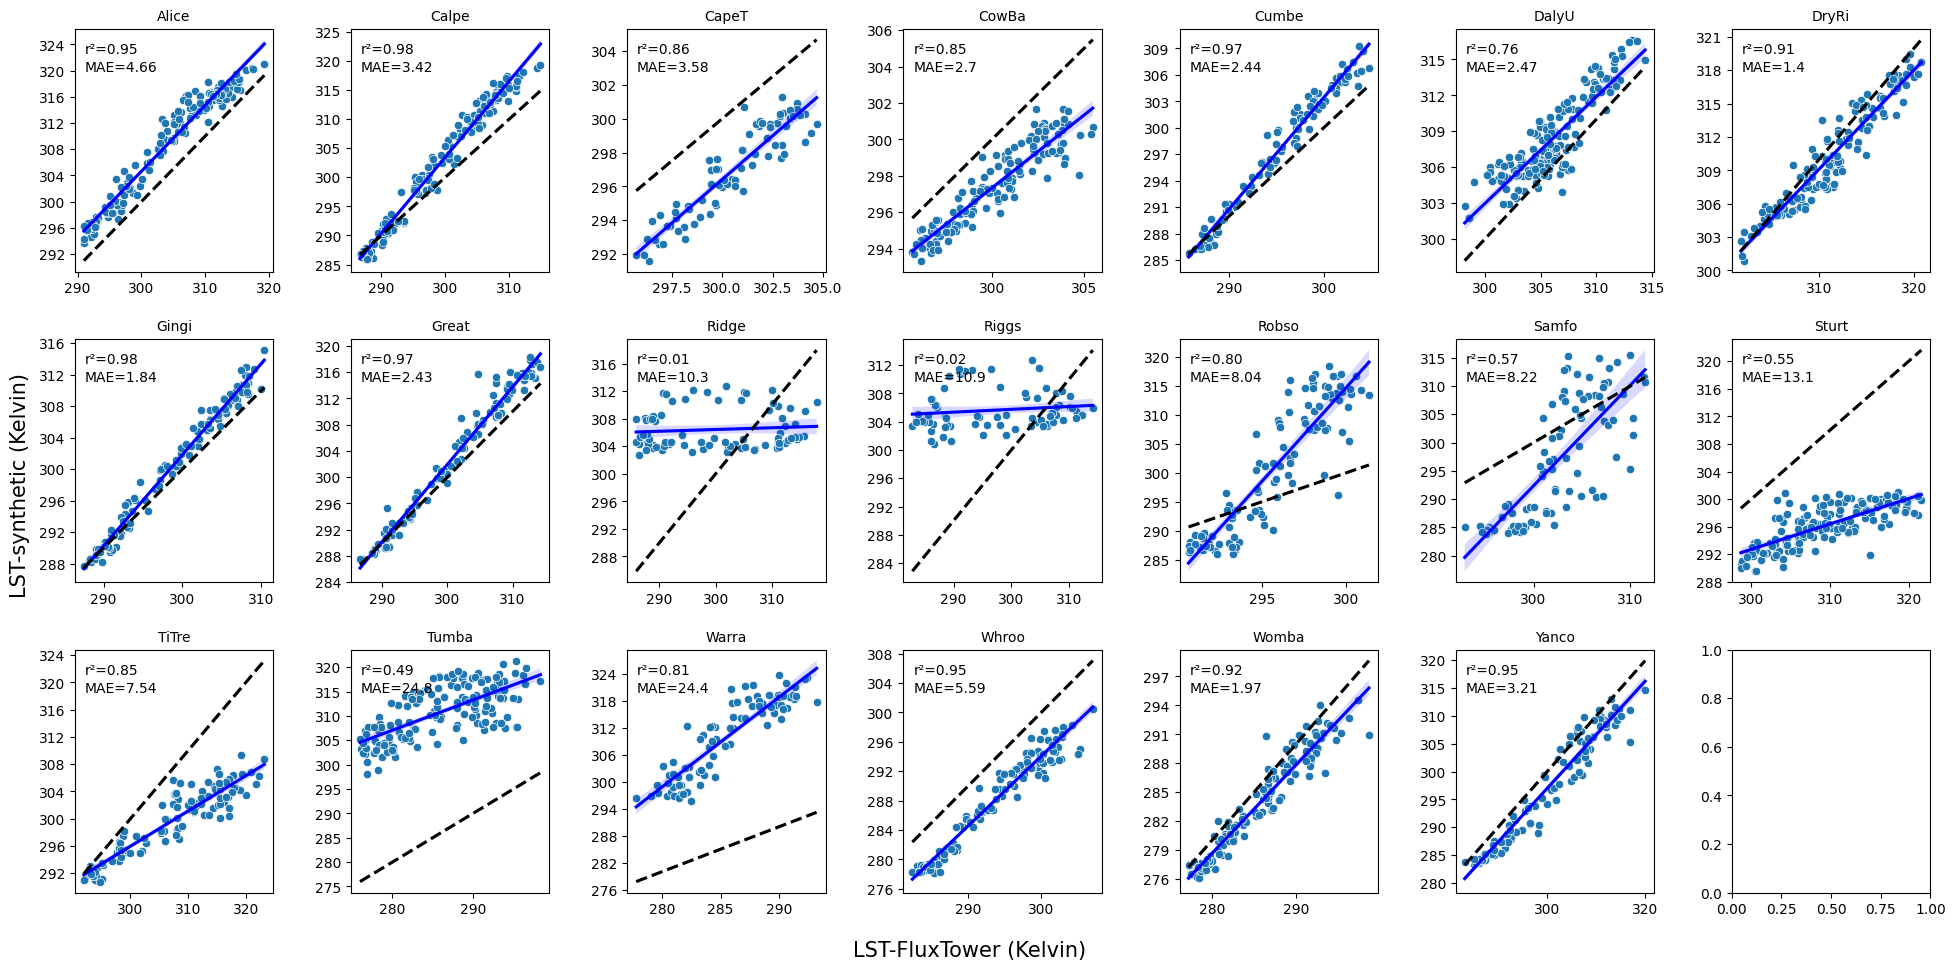

In [5]:
font=10
fig,axes = plt.subplots(3,7, figsize=(20,10))
for df, ax in zip(dffs, axes.ravel()):

    obs,pred = df['LST-Flux'].values, df['LST-'+dataset].values
    mask = ~np.isnan(obs) & ~np.isnan(pred)
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs[mask],pred[mask])
    r2 = r_value**2
    ac = mean_absolute_error(obs[mask], pred[mask])
    # xy = np.vstack([obs[mask],pred[mask]])
    # z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df, x='LST-Flux',y='LST-'+dataset, ax=ax)
    sb.regplot(data=df, x='LST-Flux',y='LST-'+dataset, scatter=False, color='blue', ax=ax)
    sb.regplot(data=df, x='LST-Flux',y='LST-Flux', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    ax.set_title(df['site'][0], fontsize=font)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_aspect(1.5)
    ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.3g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

fig.supylabel('LST-'+dataset+ ' (Kelvin)', fontsize=15)
fig.supxlabel('LST-FluxTower (Kelvin)', fontsize=15, y=0.025);
plt.tight_layout(pad=1.75)
# fig.savefig('/g/data/os22/chad_tmp/AusENDVI/results/figs/validate_LST_'+dataset+'.png', bbox_inches='tight')
